# STEP1: 전처리

In [1]:
import os
import numpy as np
import csv

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd

from contextlib import contextmanager  # 컨텍스트 관리자를 사용하기 위한 contextlib 모듈을 가져옵니다.
import time  # 시간 관련 기능을 사용하기 위한 time 모듈을 가져옵니다.
from sklearn.neighbors import NearestNeighbors  # 최근접 이웃 알고리즘을 사용하기 위한 모듈을 가져옵니다.
from sklearn.preprocessing import minmax_scale  # 데이터 스케일링을 위한 모듈을 가져옵니다.
from typing import Dict, List, Optional, Tuple  # 타입 힌트를 사용하기 위한 typing 모듈을 가져옵니다.
import seaborn as sns  # 시각화 라이브러리인 seaborn을 가져옵니다.
import gc
import traceback  # 예외 정보를 출력하기 위한 traceback 모듈을 가져옵니다.

In [2]:
combined_result_df = pd.read_csv("./DB/BTC_sum_both_10m.csv")
combined_result_df = combined_result_df.fillna(method='ffill')


### Nearest-Neighbor Features

In [3]:
N_NEIGHBORS_MAX = 80 

class Neighbors:
    def __init__(self, 
                 name: str, 
                 pivot: pd.DataFrame, 
                 p: float, 
                 metric: str = 'minkowski', 
                 metric_params: Optional[Dict] = None, 
                 exclude_self: bool = False):
        self.name = name
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
                metric_params=metric_params
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        raise NotImplementedError()

    def make_nn_feature(self, n=5, agg=np.mean) -> pd.DataFrame:
        assert self.feature_values is not None, "should call rearrange_feature_values beforehand"

        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,0], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.reset_index() # unstack().
        # print("dst.shape:", dst.shape)
        new_column_names = ['time_id', f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}'] # 3개를 예측했는데 2개만 들어왔다??
        dst.columns = new_column_names 
        return dst
    

class TimeIdNeighbors(Neighbors):
    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str) -> None:
        # feature_pivot = df.pivot(index='time_id', values=feature_col)
        # feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_df = df[['time_id', feature_col]]
        feature_df.set_index('time_id', inplace=True)
        feature_df = feature_df.fillna(feature_df.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, feature_df.shape[0], 1))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, 0] += feature_df.values[self.neighbors[:, i], 0]

        self.columns = list(feature_df.columns)
        self.index = list(feature_df.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def __repr__(self) -> str:
        return f"time-id NN (name={self.name}, metric={self.metric}, p={self.p})"


In [4]:
combined_result_df['trade.tau'] = np.sqrt(1 / combined_result_df['num_trades'])
combined_result_df['tvpl1'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_1']
combined_result_df['tvpl2'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_2'] 
combined_result_df['tvpl5'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_5'] 
combined_result_df['tvpl10'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_10'] 
combined_result_df['tvpl15'] = combined_result_df['trade_vol'] / combined_result_df['liq_last_15'] 

# 각 변수 상관관계 분석
- 주요 특성들을 관찰
- 유사한 특성을 찾고자
- 인과성을 지닌 특성이 있는지 (TLCC)

켄달 타우 상관계수 계산

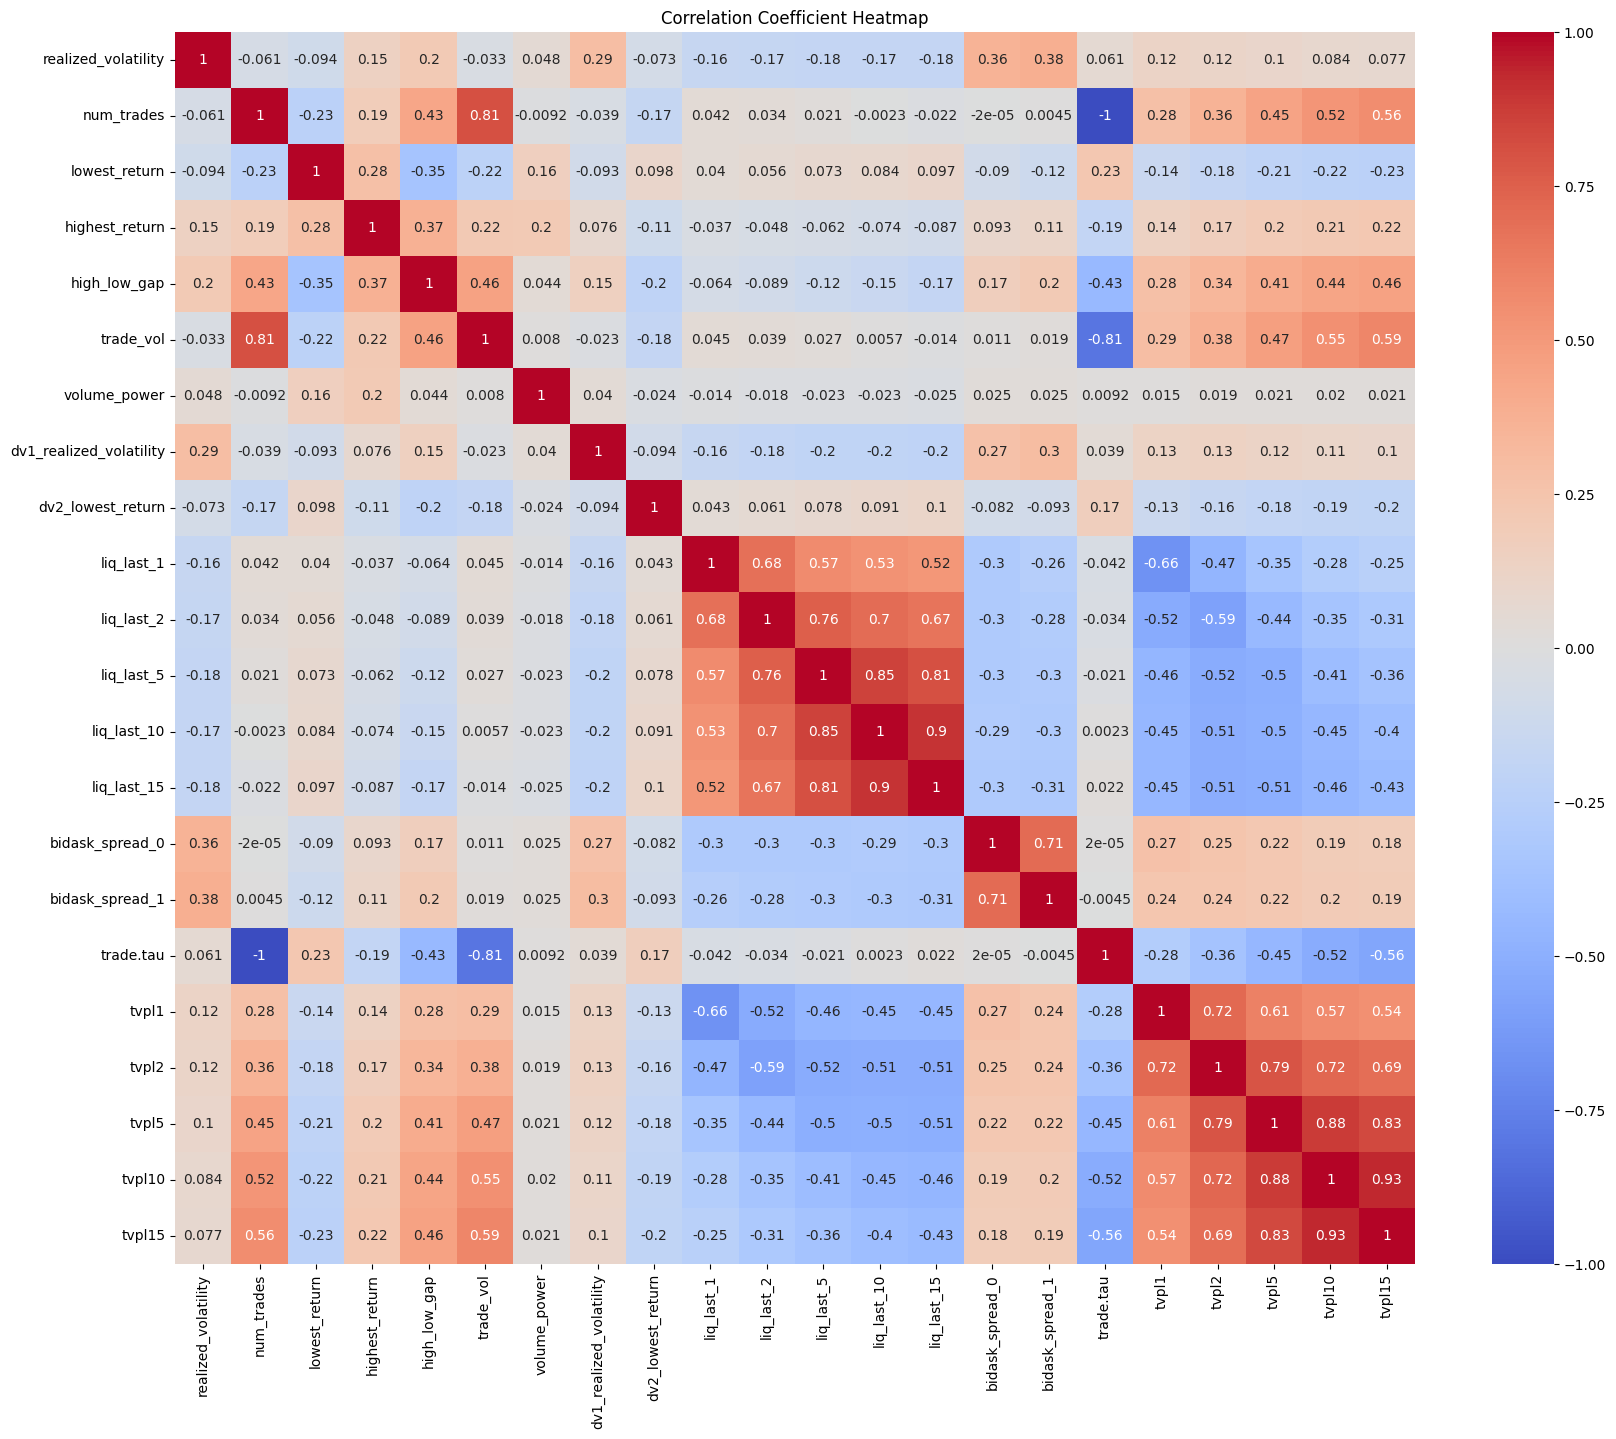

In [10]:
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

data = combined_result_df.copy()
data = data.drop(columns=['window_start', 'window_end','time_id'])



correlation_matrix = data.corr(method=lambda x, y: kendalltau(x, y).correlation)

# 히트맵 시각화
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Coefficient Heatmap')
plt.show()

append previous value

In [ ]:
# 새로운 열 생성
window_size = 50  # 이전 값의 개수
new_column_name = 'prevs_lowest_return'

# 이전 값들을 포함한 열 생성
previous_values = []
for i in range(len(combined_result_df)):
    if i < window_size:
        previous_values.append(np.array(combined_result_df['lowest_return'][:i]))
    else:
        previous_values.append(np.array(combined_result_df['lowest_return'][i - window_size : i]))

combined_result_df[new_column_name] = previous_values

combined_result_df['prevs_lowest_return']


#### Build Nearest Neighbors

In [5]:
@contextmanager
def timer(name: str):
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f'[{name}] {elapsed: .3f}초')

def print_trace(name: str = ''):
    print(f'{name or "익명"}에서 에러가 발생했습니다.')
    print(traceback.format_exc())


In [12]:
USE_LOWEST_RETURN = True
USE_VOL_NN_FEATURES = True
USE_TRADE_VOL_NN_FEATURES = True
USE_ALL_FEATURES = True

time_id_neighbors: List[Neighbors] = []

with timer('knn fit'):
    #df_pv = combined_result_df[['time_id']].copy()
    df_pv = combined_result_df.copy()
    df_pv = df_pv.drop(['window_start', 'window_end','volume_power'], axis=1)
    #df_pv['lowest_return'] = combined_result_df['lowest_return']
    #df_pv['trade.tau'] = combined_result_df['trade.tau']
    #df_pv['trade_vol'] = combined_result_df['trade_vol']
    #df_pv['realized_volatility'] = combined_result_df['realized_volatility']
    
    if USE_LOWEST_RETURN :
        df_nn = df_pv[['time_id','lowest_return']]
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())
        df_nn = pd.DataFrame(minmax_scale(df_nn))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'time_price_c', 
                df_nn, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )
       
    if USE_VOL_NN_FEATURES:
        df_nn = df_pv[['time_id','realized_volatility']]
        df_nn.set_index('time_id', inplace=True)

        # pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'vol')
        df_nn = df_nn.fillna(df_nn.mean())
        df_nn = pd.DataFrame(minmax_scale(df_nn))

        time_id_neighbors.append(
            TimeIdNeighbors('realized_volatility_m', df_nn, p=1)
        )

    if USE_TRADE_VOL_NN_FEATURES:

        df_nn = df_pv[['time_id','trade_vol']]
        df_nn.set_index('time_id', inplace=True)
        # pivot = df_pv.pivot(index='time_id', columns='stock_id', values= 'trade.size.sum')
        df_nn = df_nn.fillna(df_nn.mean())
        df_nn = pd.DataFrame(minmax_scale(df_nn))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'trade_vol_c', 
                df_nn, 
                p=2, 
                metric='canberra'
            )
        )
    # 데이터의 모든 특성을 기반으로 NN Search
    # realized_volatility와 상관계수가 높은 혹은 낮은 N개의 NN으로 
    # 추가 Feature 생성 가능
    if USE_ALL_FEATURES:
        df_nn = df_pv.copy()
        df_nn = df_nn.drop(['dv1_realized_volatility'], axis=1)
        df_nn.set_index('time_id', inplace=True)
        df_nn = df_nn.fillna(df_nn.mean())
        df_nn = pd.DataFrame(minmax_scale(df_nn))

        time_id_neighbors.append(
            TimeIdNeighbors(
                'all_nn_c', 
                df_nn, 
                p=2, 
                metric='canberra', 
                exclude_self=True
            )
        )

        time_id_neighbors.append(
            TimeIdNeighbors(
                'all_nn_m', 
                df_nn, 
                p=2, 
                exclude_self=True
            )
        )


In [7]:
import pickle
with open('time_id_neighbors.pickle', 'rb') as file:
    time_id_neighbors = pickle.load(file)


#### Check Neighbor Indices

In [ ]:
def calculate_rank_correraltion(neighbors, top_n=10):
    if not neighbors:
        return
    neighbor_indices = pd.DataFrame()
    for n in neighbors:
        neighbor_indices[n.name] = n.neighbors[:,:top_n].flatten()
        display(neighbor_indices[n.name])
    sns.heatmap(neighbor_indices.corr('kendall'), annot=True)
    

In [ ]:
time_ids = np.array(sorted(combined_result_df['time_id'].unique()))
for neighbor in time_id_neighbors:
    print(neighbor)
    display(
        pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).iloc[1:6]
    )
    print(pd.DataFrame(
            time_ids[neighbor.neighbors[:,:10]], 
            index=pd.Index(time_ids, name='time_id'), 
            columns=[f'top_{i+1}' for i in range(10)]
        ).shape)

In [ ]:
calculate_rank_correraltion(time_id_neighbors)

#### Aggregate Features With Neighbors

In [8]:
def make_nearest_neighbor_feature(df: pd.DataFrame) -> pd.DataFrame:
    df2 = combined_result_df.copy()
    print(df2.shape)
    USE_LOWEST_RETURN = True
    ### time_id를 기준으로 얻어진 neighbor를 대상으로 feature 만들기
    feature_cols = {
        'realized_volatility': [np.mean, np.min, np.max, np.std],
        'lowest_return': [np.max, np.mean, np.min],
        'num_trades': [np.mean],
        'trade.tau': [np.mean],
        'trade_vol': [np.mean],
        'dv1_realized_volatility': [np.mean],
    }

    time_id_neigbor_sizes = [3, 5, 10, 20, 40]
    time_id_neigbor_sizes_vol = [2, 3, 5, 10, 20, 40]

    ndf: Optional[pd.DataFrame] = None
    
    # 새로운 feature를 기존 df에 추가하는 함수
    def _add_ndf(ndf: Optional[pd.DataFrame], dst: pd.DataFrame) -> pd.DataFrame:
        if ndf is None:
            return dst
        else:
            ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
            return ndf

    # neighbor time_id
    for feature_col in feature_cols.keys():
        try:
            if not USE_LOWEST_RETURN and feature_col == 'lowest_return':
                continue
            if feature_col not in df2.columns:
                print(f"column {feature_col} is skipped")
                continue
            
            for nn in time_id_neighbors:
                nn.rearrange_feature_values(df2, feature_col)

            if 'realized_volatility' in feature_col:
                time_id_ns = time_id_neigbor_sizes_vol
            else:
                time_id_ns = time_id_neigbor_sizes

            for agg in feature_cols[feature_col]:
                for n in time_id_ns:
                    try:
                        for nn in time_id_neighbors:
                            dst = nn.make_nn_feature(n, agg)
                            ndf = _add_ndf(ndf, dst)
                    except Exception:
                        print_trace('time-id nn')
                        pass
        except Exception:
            print_trace('time-id nn')

    if ndf is not None:
        df2 = pd.merge(df2, ndf, on=['time_id'], how='left')
    
    print(df2.shape)

    # features further derived from nearest neighbor features
    try:
        if USE_LOWEST_RETURN:
            for sz in time_id_neigbor_sizes:
                denominator = f"lowest_return_nn{sz}_time_price_c"

                df2[f'lowest_return_rankmin_{sz}']  = df2['lowest_return'] / df2[f"{denominator}_amin"]
                df2[f'lowest_return_rankmax_{sz}']  = df2['lowest_return'] / df2[f"{denominator}_amax"]
                df2[f'lowest_return_rankmean_{sz}'] = df2['lowest_return'] / df2[f"{denominator}_mean"]

            for sz in time_id_neigbor_sizes_vol:
                denominator = f"realized_volatility_nn{sz}_time_price_c"

                df2[f'vol_rankmin_{sz}'] = \
                    df2['realized_volatility'] / df2[f"{denominator}_amin"]
                df2[f'vol_rankmax_{sz}'] = \
                    df2['realized_volatility'] / df2[f"{denominator}_amax"]

        price_cols = [c for c in df2.columns if 'lowest_return' in c and 'rank' not in c]
        for c in price_cols:
            del df2[c]


    except Exception:
        print_trace('nn features')
    
    print(df2.shape)
    
    return df2

In [9]:
gc.collect()

with timer('make nearest neighbor feature'):
    df3 = make_nearest_neighbor_feature(combined_result_df)

print(df3.shape)
#df2.reset_index(drop=True).to_feather('optiver_df2.f')

gc.collect()

(102336, 25)


C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ndf[dst.columns[-1]] = dst[dst.columns[-1]].astype(np.float32)
C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

(102336, 325)
(102336, 275)
[make nearest neighbor feature]  15.861초
(102336, 275)


C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'lowest_return_rankmin_{sz}']  = df2['lowest_return'] / df2[f"{denominator}_amin"]
C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[f'lowest_return_rankmax_{sz}']  = df2['lowest_return'] / df2[f"{denominator}_amax"]
C:\Users\samsung\AppData\Local\Temp\ipykernel_292\2986459955.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is u

0

In [11]:
target_value = "dv1_realized_volatility"
predict_list = []
for item in df3.columns:
    if target_value in item:
        predict_list.append(item)

In [13]:
predict_list = predict_list[1:]

In [ ]:
def custom_loss(y_true, y_pred):
    return sum(abs(y_true - y_pred))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))
    
predict = {}
for item in predict_list :
    predict[item] = custom_loss(
        np.array(df3["dv1_realized_volatility"]),
        np.array(df3[item])
    )

value 값이 가장 작은 8개 출력


In [50]:
sorted_items = sorted(predict.items(), key=lambda x: x[1])

# 가장 작은 8개 아이템 출력
for key, value in sorted_items[:20]:
    print(key, value)

dv1_realized_volatility_nn20_all_nn_m_mean 0.40978864940033766
dv1_realized_volatility_nn10_all_nn_m_mean 0.4234948745719137
dv1_realized_volatility_nn40_all_nn_m_mean 0.43371766055832983
dv1_realized_volatility_nn5_all_nn_m_mean 0.4861591549139067
dv1_realized_volatility_nn3_all_nn_m_mean 0.5912426338213885
dv1_realized_volatility_nn2_all_nn_m_mean 0.757307286691064
dv1_realized_volatility_nn10_all_nn_c_mean 3.1903099862608757
dv1_realized_volatility_nn5_all_nn_c_mean 3.245218861956806
dv1_realized_volatility_nn20_all_nn_c_mean 3.289762547087431
dv1_realized_volatility_nn40_all_nn_c_mean 3.4505698788485493
dv1_realized_volatility_nn3_all_nn_c_mean 3.4715990658027582
dv1_realized_volatility_nn2_all_nn_c_mean 3.941726899936275
dv1_realized_volatility_nn2_realized_volatility_m_mean 3.964958209128149
dv1_realized_volatility_nn2_trade_vol_c_mean 4.432924631724105
dv1_realized_volatility_nn3_realized_volatility_m_mean 4.599029370878641
dv1_realized_volatility_nn5_realized_volatility_m_mean 